# Training and maintaining MNIST predictions

In this notebook we'll be implementing a classic machine learning classification task: MNIST hand written digit
recognition, using a convolution neural network, but with a twist: we'll be implementing the task *in database* using SuperDuperDB.

SuperDuperDB supports MongoDB as a databackend. Correspondingly, we'll import the python MongoDB client `pymongo`
and "wrap" our database to convert it to a SuperDuper `Datalayer`:

In [1]:
import pymongo
import torch
import torchvision

from superduperdb import superduper

db = pymongo.MongoClient().documents

db = superduper(db)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
pymongo.MongoClient().drop_database('documents')
pymongo.MongoClient().drop_database('_filesystem:documents')

Now that we've connected to SuperDuperDB, let's add some data. MNIST is a good show case for one of the 
key benefits of SuperDuperDB - adding "difficult" data types. This can be done using an `Encoder` 
which is a key wrapper in SuperDuperDB's arsenal. The `Encoder` works closely together with the `Document` 
wrapper. Together they allow Python dictionaries containing non-JSONable/ `bytes` objects, to be insert into
SuperDuperDB:

In [3]:
from superduperdb.encoders.pillow.image import pil_image as i
from superduperdb.core.document import Document as D
from superduperdb.datalayer.mongodb.query import Collection

import random

collection = Collection(name='mnist')

mnist_data = list(torchvision.datasets.MNIST(root='./data', download=True))
data = [D({'img': i(x[0]), 'class': x[1]}) for x in mnist_data]
random.shuffle(data)
data = data[:11000]

db.execute(
    collection.insert_many(data[:-1000], encoders=[i])
)

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x1805615d0>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x17c988e90>, G=<networkx.classes.digraph.DiGraph object at 0x173534f50>))

Now that we've inserted the images and their classes to the database, let's query some data:

In [4]:
r = db.execute(collection.find_one())
r

Document({'_id': ObjectId('64bef37a07b0de43146e9c2d'), 'img': Encodable(x=<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x17FF6BC10>, encoder=Encoder(identifier='pil_image', decoder=<Artifact artifact=<function decode_pil_image at 0x17d4abd80> serializer=dill>, encoder=<Artifact artifact=<function encode_pil_image at 0x17d4a8e00> serializer=dill>, shape=None, version=0)), 'class': 7, '_fold': 'train'})

When we query the data, it's in exactly the format we inserted it. In particular, we can use the `PIL.Image` instances
to inspect the data:

In [5]:
r['img'].x

Now let's create our model. SuperDuperDB supports these frameworks, out-of-the-box:

- `torch`
- `sklearn`
- `transformers`
- `sentence_transformers`
- `openai`
- `langchain`

In this case, we're going to use PyTorch, since it's great for computer vision use-cases.
We can combine `torch` with `torchvision` in SuperDuperDB.

In [6]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(400, 120)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(120, 84)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    
def postprocess(x):
    return int(x.topk(1)[1].item())


def preprocess(x):
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
    )(x)

We've created `postprocess` and `preprocess` functions to handle the communication with the SuperDuperDB
`Datalayer`. In order to create a native SuperDuperDB model, we wrap the model, preprocessing and postprocessing:

In [7]:
model = superduper(LeNet5(10), preprocess=preprocess, postprocess=postprocess)

The model predicts human readable outputs, directly from the `PIL.Image` objects. All 
models in SuperDuperDB are equipped with a `sklearn`-style `.predict` method. This makes 
it easy to know how each AI-framework will operate in combination with the `Datalayer`.

In [8]:
model.predict([r['img'] for r in data[:10]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 260.82it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Now we're ready to "train" or "fit" the model. Trainable models in SuperDuperDB are equipped 
with a `sklearn`-like `.fit` method:

In [9]:
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from superduperdb.core.metric import Metric
from superduperdb.metrics.classification import compute_classification_metrics
from superduperdb.core.dataset import Dataset
from superduperdb.models.torch.wrapper import TorchTrainerConfiguration


job = model.fit(
    X='img',
    y='class',
    db=db,
    select=collection.find(),
    configuration=TorchTrainerConfiguration(
        identifier='my_configuration',
        objective=cross_entropy,
        loader_kwargs={'batch_size': 10},
        max_iterations=100,
        validation_interval=50,
        compute_metrics=compute_classification_metrics,
    ),
    metrics=[Metric(identifier='acc', object=lambda x, y: x == y)],
    validation_sets=[
        Dataset(
            identifier='my_valid',
            select=Collection(name='mnist').find({'_fold': 'valid'}),
        )
    ],
    distributed=False
)

INFO:root:fold: TRAIN; iteration: 0; objective: 2.3030130863189697; 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 497/497 [00:00<00:00, 737.65it/s]
INFO:root:fold: VALID; iteration: 0; my_valid/acc: 0.15090543259557343; objective: 2.293396143913269; 
INFO:root:fold: TRAIN; iteration: 1; objective: 2.3209638595581055; 
INFO:root:fold: TRAIN; iteration: 2; objective: 2.377978801727295; 
INFO:root:fold: TRAIN; iteration: 3; objective: 2.314385175704956; 
INFO:root:fold: TRAIN; iteration: 4; objective: 2.3264107704162598; 
INFO:root:fold: TRAIN; iteration: 5; objective: 2.1973912715911865; 
INFO:root:fold: TRAIN; iteration: 6; objective: 2.2388699054718018; 
INFO:root:fold: TRAIN; iteration: 7; objective: 2.1599698066711426; 
INFO:root:fold: TRAIN; iteration: 8; objective: 2.304192066192627; 
INFO:root:fold: TRAIN; iteration: 9; objective: 2.1507439613342285; 
INFO:root:fold: TRA

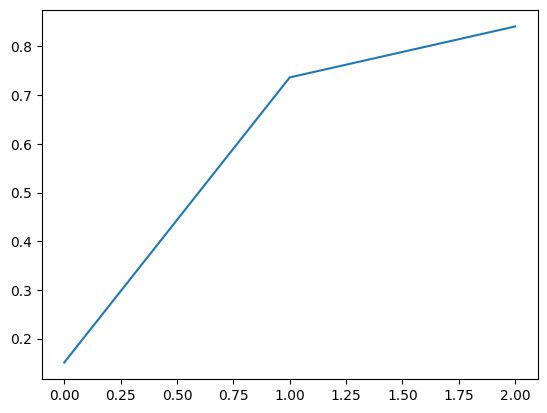

In [10]:
from matplotlib import pyplot as plt

model = db.load('model', model.identifier)

plt.plot(model.metric_values['my_valid/acc'])
plt.show()

Now that the model has been trained, we can use it to "watch" the data for incoming changes. 
This is set up with a simple predict "on" the database (without loading all the data client-side).

The `watch` toggle "activates" the model:

In [11]:
model.predict(X='img', db=db, select=collection.find(), watch=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 890.50it/s]


We can see that predictions are available in `_outputs.img.lenet5`:

In [12]:
db.execute(collection.find_one())

Document({'_id': ObjectId('64bef37a07b0de43146e9c2d'), 'img': Encodable(x=<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x18272B510>, encoder=Encoder(identifier='pil_image', decoder=<Artifact artifact=<function decode_pil_image at 0x17d4abd80> serializer=dill>, encoder=<Artifact artifact=<function encode_pil_image at 0x17d4a8e00> serializer=dill>, shape=None, version=0)), 'class': 7, '_fold': 'train', '_outputs': {'img': {'lenet5': 7}}})

The models "activated" can be seen here:

In [13]:
db.show('watcher')

['lenet5/img']

We can verify that the model is activated, by inserting the rest of the data:

In [14]:
for r in data[-1000:]:
    r['update'] = True

db.execute(collection.insert_many(data[-1000:]))

INFO:root:found 0 uris
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 834.97it/s]


(<pymongo.results.InsertManyResult at 0x1815aaf50>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x17c988e90>, G=<networkx.classes.digraph.DiGraph object at 0x17d4b1650>))

You can see that the inserted data, are now also populated with predictions:

In [15]:
db.execute(collection.find_one({'update': True}))['_outputs']

{'img': {'lenet5': 0}}